# Interpretation techniques

Author: Frantisek Sefcik

### Setup and import libraries

In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from tensorflow.python.util import module_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

Using TensorFlow backend.


In [4]:
import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

from helpers import plots, evaluation, utils, data_utils

### Initialize Model

We will load model from previously trained model in [classification_4_lgg_vs_hgg](./classification_4_lgg_vs_hgg.ipynb)

In [5]:
model = load_model('../models/hggvgg_model_12.h5')
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_a (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
max_a (MaxPooling2D)         (None, 120, 120, 16)      0         
_________________________________________________________________
batch_norm (BatchNormalizati (None, 120, 120, 16)      64        
_________________________________________________________________
drop_a (Dropout)             (None, 120, 120, 16)      0         
_________________________________________________________________
conv_b (Conv2D)              (None, 120, 120, 32)      4640      
_________________________________________________________________
max_b (MaxPooling2D)         (None, 60, 60, 32)        0         
_________________________________________________________________
conv_c (Conv2D)              (None, 60, 60, 64)        18496     
__________

### Load Data

We will create LggHggGenerator which can return generators for brain image, tumor segmentation images or generator for pairs of brain image with tumor segmentation.

In [7]:
image_dir = '../data/valid/confidence_19/'
seg_dir = '../data/valid/seg_confidence_19/'

image_generator = ImageDataGenerator(rescale=1./255)
seg_generator = ImageDataGenerator()

lgg_hgg_generator = data_utils.LggHggGenerator(image_generator, seg_generator, image_dir, seg_dir)

val_gen = lgg_hgg_generator.get_image_generator()
val_seg_gen = lgg_hgg_generator.get_seg_generator()

Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.


Examples of data

[1. 1. 0. 1. 0.]


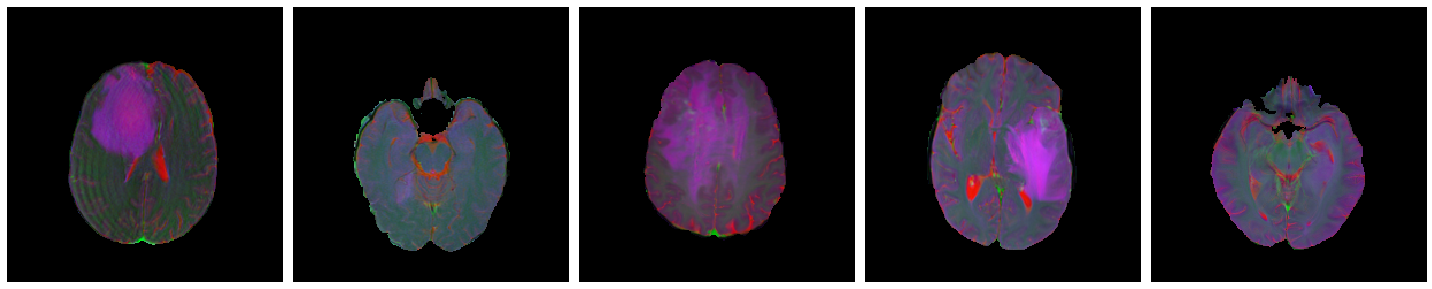

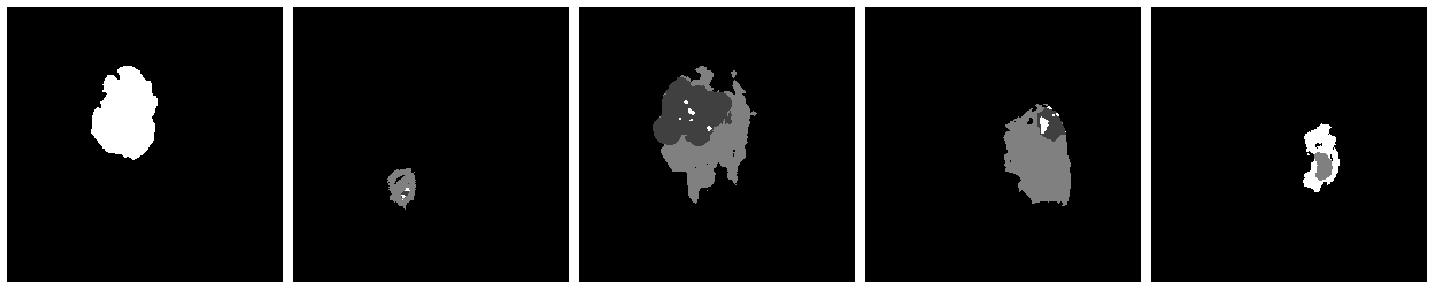

In [8]:
x, y = next(val_gen)
x_seg, y_seg = next(val_seg_gen)
print(y[:5])
plots.plot_rgb_images(x[:5])
plots.plot_gray_images(x_seg[:5])

## Define Analyzers

We will use library [Innvestigate](https://github.com/albermax/innvestigate) for many of neural networks interpretations techniques.

In [9]:
def bk_proj(X):
    X = ivis.clip_quantile(X, 1)
    return ivis.project(X)
def heatmap(X):
    return ivis.heatmap(X)
def graymap(X):
    return ivis.graymap(np.abs(X), input_is_positive_only=True)

methods = [
    # Function
    ("gradient",              {"postprocess": "abs"},   graymap,        "Gradient"),
    ("smoothgrad",            {}                       ,graymap,        "SmoothGrad"),
    # Signal
    ("deconvnet",             {},                       bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       bk_proj,        "Guided Backprop",),
    # Interaction
    ("input_t_gradient",      {},                       heatmap,        "Input * Gradient"),
    ("lrp.z",                 {},                       heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           heatmap,        "LRP-Epsilon")
]

# Create analyzers.
analyzers = []
for method in methods:
    print(method[3])
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    analyzers.append(analyzer)

Gradient
SmoothGrad
Deconvnet
Guided Backprop
Input * Gradient
LRP-Z
LRP-Epsilon


### Visualization of all initialized analyzers

In [10]:
channels_first = keras.backend.image_data_format() == "channels_first"
color_conversion = None
def postprocess(X, color_conversion, channels_first):
    X = X.copy()
    X = iutils.postprocess_images(
        X, color_coding=color_conversion, channels_first=channels_first)
    return X


n = 5
val_images, val_labels = next(val_gen)
test_images = list(zip(val_images[:n], val_labels[:n]))
label_to_class_name = { 0: '0', 1: '1'}

text = []
analysis = np.zeros([len(test_images), len(analyzers), 240, 240, 3])

for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        a = analyzer.analyze(x)
        a = postprocess(a, color_conversion, channels_first)
        a = methods[aidx][2](a)
        img = a[0]
        analysis[i, aidx] = img

<Figure size 432x288 with 0 Axes>

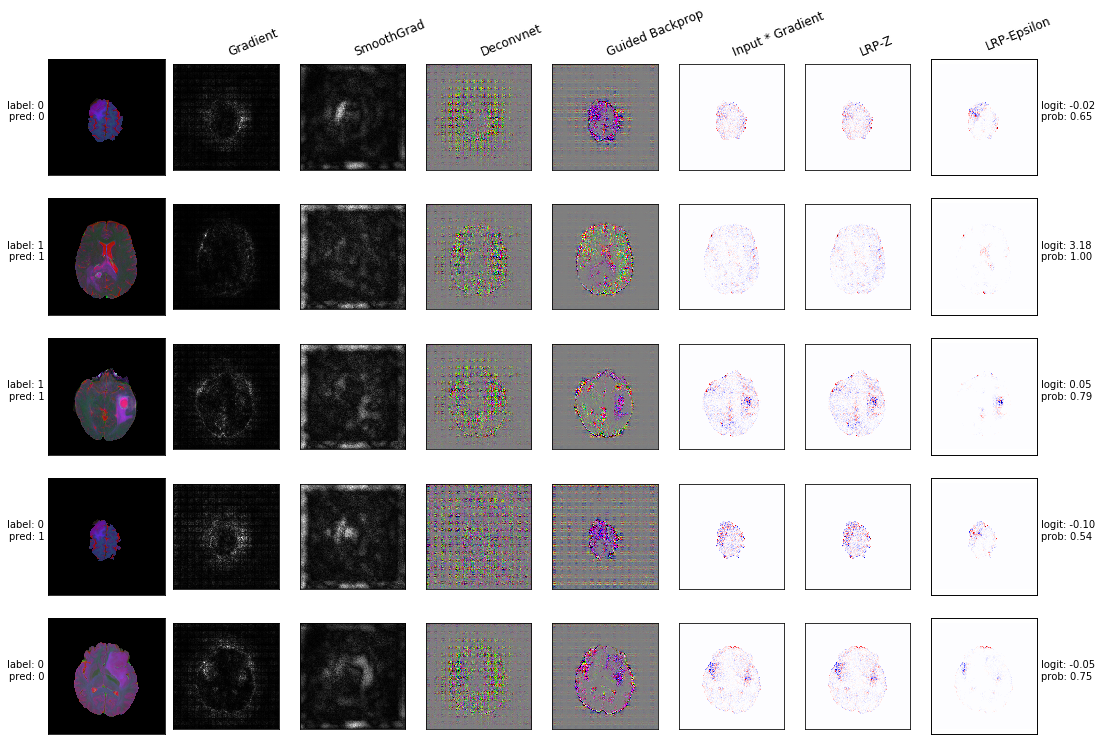

In [11]:
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# # Prepare the labels
label, presm, prob, pred = zip(*text)
# row_labels_left = [['label: {}'.format(l)] for l in val_labels[:n]]
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]
plots.plot_image_grid(val_images[:n],
                      grid,row_labels_left,
                      row_labels_right,
                      col_labels,figsize=(20,15))

## Evaluate interpretation with analyzer

We will select one of above defined analyzers and analyzer will by use to comprehensive analysis of models prediction.

##### Select one of analyzers

In [12]:
# For now we will select LRP-Epsilon technique
analyzer = analyzers[6]

##### Create generator

As a first we will create generator for original images and images with segmentation of tumor

In [13]:
num_of_test_samples = 428
batch_size = 5
generator = lgg_hgg_generator.get_image_seg_generator(batch_size)

Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.


##### Visualization of selected technique

In the picture you can see from left: report with ground truth label, prediction, probability and our metric score, next is original picture of brain, segmentation of tumor and last is saliency map of interpretation technique.

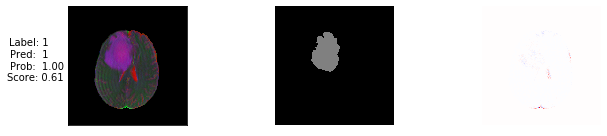

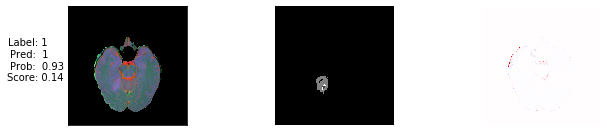

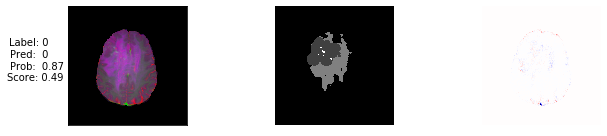

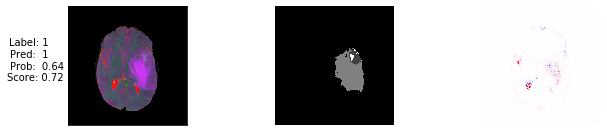

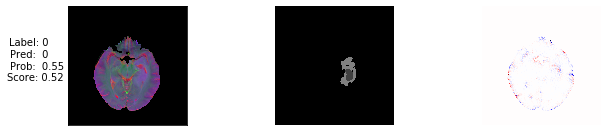

In [14]:
(x, y),(x_seg, y_seg) = next(generator)
evaluation.visualize_method(model, analyzer, x, x_seg, y)

### Statistics

Lets plot some statistics obtained from metric

#### Count metric

In second step we run metrics over all validation images

In [15]:
metrics = evaluation.evaluate_method_generator(model, analyzer, generator, num_of_test_samples, batch_size)

In [16]:
(y, pred, prob, score) = np.stack(np.array(list(metrics)), axis=-1)

##### Distribution of metrics values for samples from each predicted class

              1        0
mean:    |  0.58  |  0.66  |
std:     |  0.20  |  0.17  |
min:     |  0.09  |  0.13  |
max:     |  0.91  |  0.93  |
median:  |  0.60  |  0.71  |


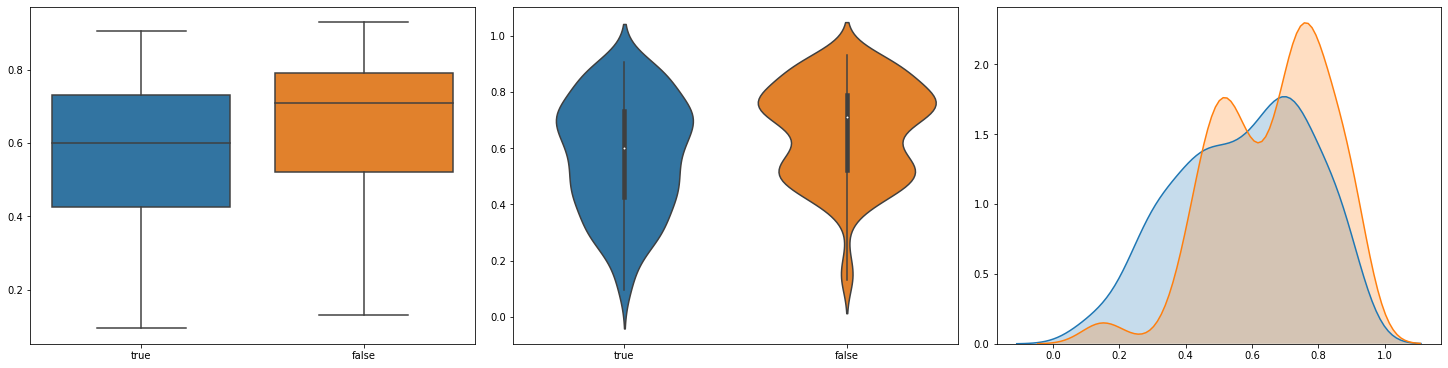

In [17]:
plots.plot_data_distribution(score[pred==1], score[pred==0])

#### Metrics for network prediction

Model performance:
              precision    recall  f1-score   support

         0.0       0.73      0.81      0.77       185
         1.0       0.84      0.77      0.80       240

    accuracy                           0.79       425
   macro avg       0.78      0.79      0.78       425
weighted avg       0.79      0.79      0.79       425



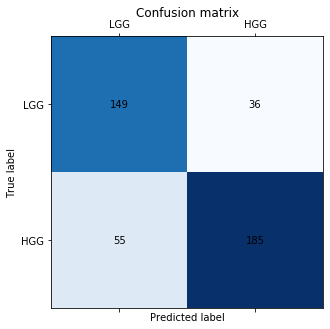

Analyzer performance:


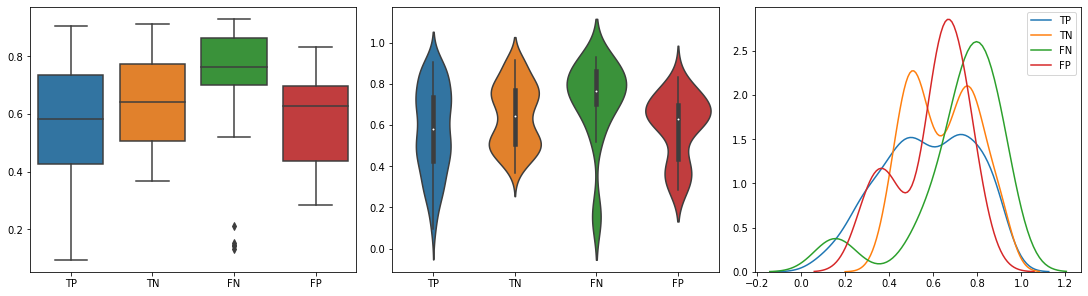

In [18]:
plots.plot_model_performance(y,pred)
plots.plot_data_distribution_groups(y, pred, score)

### Metrics of interpretation score cross tumor regions

Segmentation of tumor is divided into 4 tumor regions. Each region shows some specific tumor tissue with different level of aggresiveness. From previous analysis we decided to skip 3 type of region for next analysis, because it doesnt occure in images.

In the picture is the same visualization for interpretation as above, but we enriched each line with barplot, which shows metrics values obtained individualy for each tumor region.

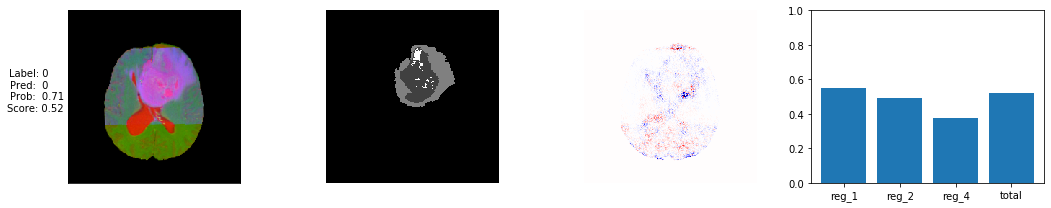

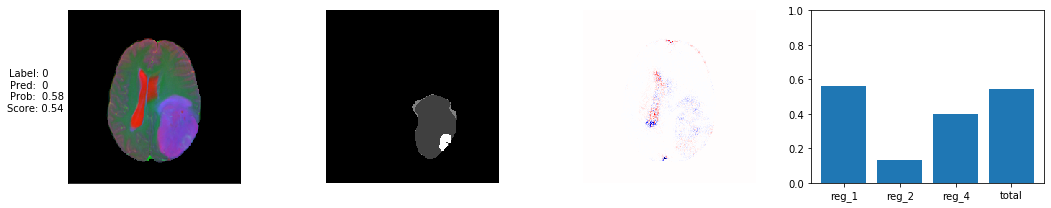

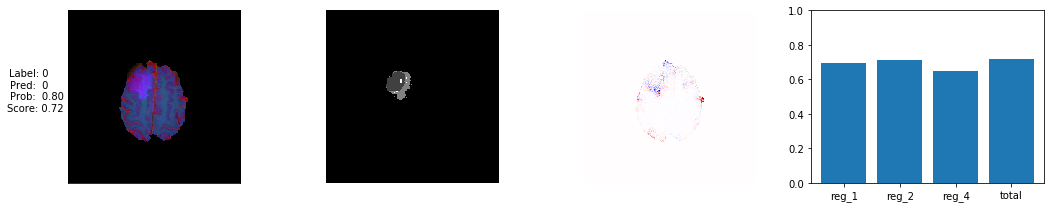

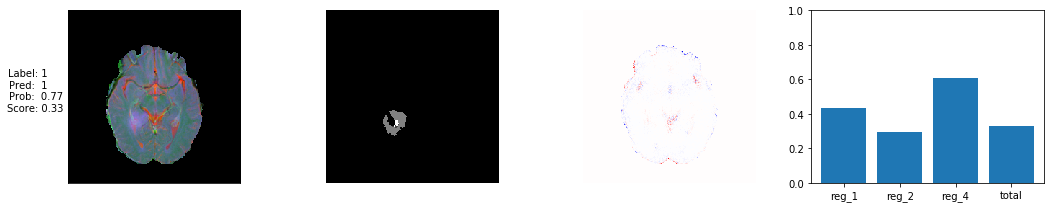

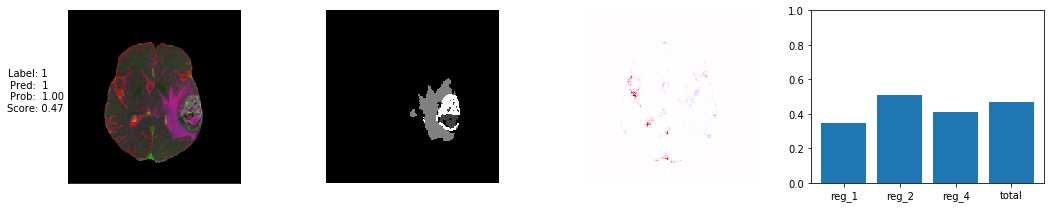

In [15]:
(x, y),(x_seg, y_seg) = next(generator)
evaluation.visualize_method_by_regions(model, analyzer, x, x_seg, y)

#### Kvantitative statistics for each tumor region

Our metric will by evaluated for each tumor region cross all confusion matrics groups (TP, TN, FN, FP)

In [16]:
num_of_test_samples = 446
batch_size = 6
metrics = evaluation.evaluate_method_generator(model, analyzer,lgg_hgg_generator.get_image_seg_generator(batch_size), 
                                                    num_of_test_samples, batch_size, 0)
reg1_metrics = evaluation.evaluate_method_generator(model, analyzer, 
                                                    lgg_hgg_generator.get_image_seg_generator(batch_size), 
                                                    num_of_test_samples, batch_size, 1)
reg2_metrics = evaluation.evaluate_method_generator(model, analyzer, 
                                                    lgg_hgg_generator.get_image_seg_generator(batch_size), 
                                                    num_of_test_samples, batch_size, 2)
reg4_metrics = evaluation.evaluate_method_generator(model, analyzer, 
                                                    lgg_hgg_generator.get_image_seg_generator(batch_size), 
                                                    num_of_test_samples, batch_size, 4)

Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.


In [17]:
(y, pred, prob, score_regt) = np.stack(np.array(list(metrics)), axis=-1) # all together
(y1, pred1, prob1, score_reg1) = np.stack(np.array(list(reg1_metrics)), axis=-1) # 1 region
(y2, pred2, prob2, score_reg2) = np.stack(np.array(list(reg2_metrics)), axis=-1) # 2 region
(y4, pred4, prob4, score_reg4) = np.stack(np.array(list(reg4_metrics)), axis=-1) # 4 region

##### All regions together

Analyzer performance:


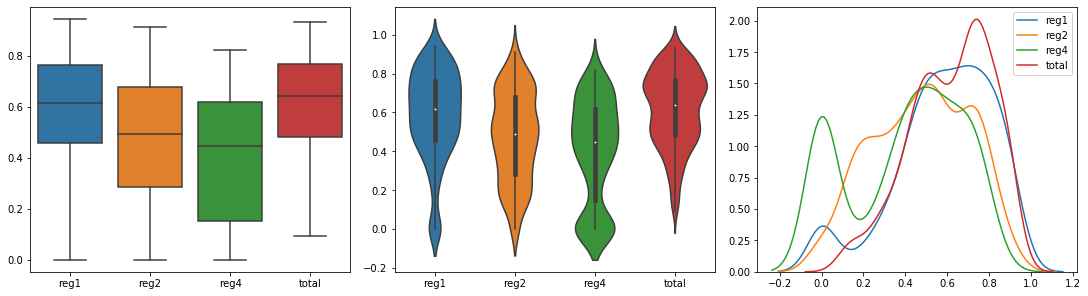

In [18]:
plots.plot_statistics_groups(scores=[score_reg1, score_reg2, score_reg4, score_regt], names=['reg1','reg2','reg4','total'])

##### Region 1

Analyzer performance:


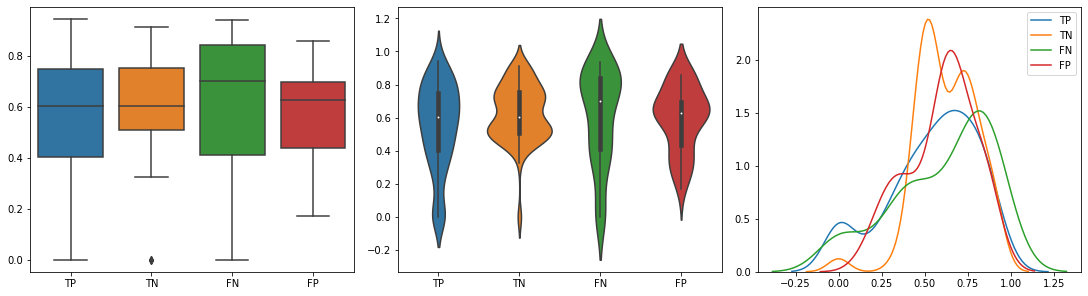

In [19]:
plots.plot_data_distribution_groups(y, pred, score_reg1)

##### Region 2

Analyzer performance:


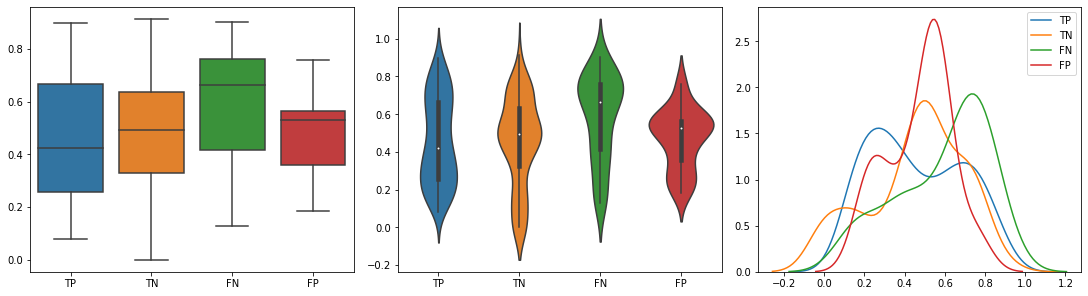

In [20]:
plots.plot_data_distribution_groups(y, pred, score_reg2)

##### Region 4

Analyzer performance:


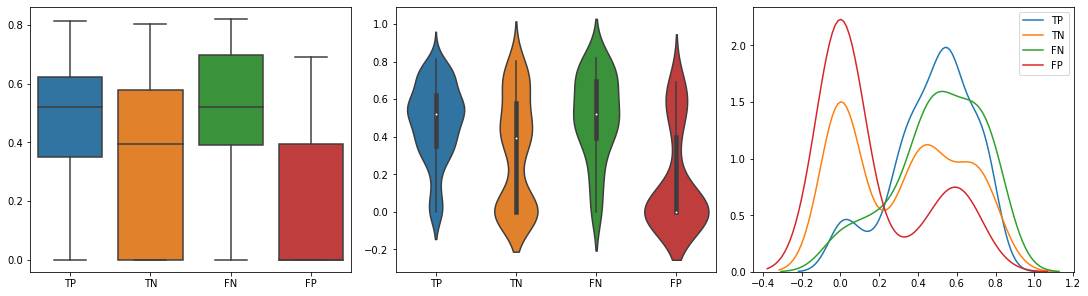

In [21]:
plots.plot_data_distribution_groups(y, pred, score_reg4)

### Evaluation of statistics

We will use above defined statistics to create method which could help to understand or improve prediction of model.

##### Scatterplot shows relation between prediction probability and our metrics

We can see that true prediction of positive class (TP) achieve very hight probability of prediction (for most samples equal to 100%). Also we can see same relations of achieved interpretation score and predicted group.

Text(0.5, 1.0, 'Scatterplot')

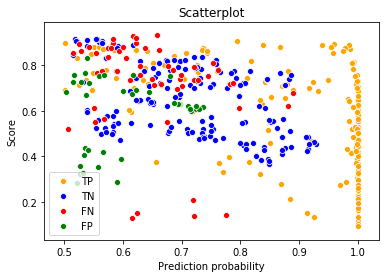

In [22]:
groups = utils.indexes_predicted_groups(y, pred)
sns.scatterplot(x=prob[groups['tp']], y=score_regt[groups['tp']], color='orange', label="TP")
sns.scatterplot(x=prob[groups['tn']], y=score_regt[groups['tn']], color='blue', label="TN")
sns.scatterplot(x=prob[groups['fn']], y=score_regt[groups['fn']], color='red', label="FN")
sns.scatterplot(x=prob[groups['fp']], y=score_regt[groups['fp']], color='green', label="FP")
plt.xlabel('Prediction probability')
plt.ylabel('Score')
plt.title('Scatterplot')

### KNN

From previously analysis of metric score in tumors regions we identified some differences between predicted groups (confusion matrix groups). These differences can be helpfull to distinguish if prediction is true or false. 

We will train KNN classifier with data obtained from model predictions and defined interpretation metrics.

##### Create training data

Trainning attributes will be: 
* score of tumor region 1
* score of tumor region 2
* score of tumor region 4
* scoro of total tumor region
* predicted label
* predicted probability

Predicted class will be: TP, TN, FN, FP

In [24]:
x_train = list(zip(score_regt, score_reg1, score_reg2, score_reg4, pred, prob))
y_train = np.zeros(len(x_train))

groups = utils.indexes_predicted_groups(y, pred)
y_train[groups['tp']] = 0
y_train[groups['tn']] = 1
y_train[groups['fn']] = 2
y_train[groups['fp']] = 3

#####  Train KNN
We will train knn to predict if prediction is true of false.

In [25]:
neigh = KNeighborsClassifier(n_neighbors=4)

In [26]:
neigh.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

#### Test with unknown data

We will load test data which NN model and also KNN model doesnt know.

In [29]:
image_test_dir = '../data/test/confidence_19/'
seg_test_dir = '../data/test/seg_confidence_19/'
test_generator = data_utils.LggHggGenerator(image_generator, seg_generator, image_test_dir, seg_test_dir)

##### Count metrics for test data

We will count metrics values for each region as before for valid data.

In [30]:
num_of_test_samples = 246
batch_size = 6
metrics = evaluation.evaluate_method_generator(model, analyzer,test_generator.get_image_seg_generator(batch_size), 
                                                    num_of_test_samples, batch_size, 0)
reg1_metrics = evaluation.evaluate_method_generator(model, analyzer, 
                                                    test_generator.get_image_seg_generator(batch_size), 
                                                    num_of_test_samples, batch_size, 1)
reg2_metrics = evaluation.evaluate_method_generator(model, analyzer, 
                                                    test_generator.get_image_seg_generator(batch_size), 
                                                    num_of_test_samples, batch_size, 2)
reg4_metrics = evaluation.evaluate_method_generator(model, analyzer, 
                                                    test_generator.get_image_seg_generator(batch_size), 
                                                    num_of_test_samples, batch_size, 4)

Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [31]:
(y_test, pred_test, prob_test, score_regt_test) = np.stack(np.array(list(metrics)), axis=-1) # all together
(_, _, _, score_reg1_test) = np.stack(np.array(list(reg1_metrics)), axis=-1) # 1 region
(_, _, _, score_reg2_test) = np.stack(np.array(list(reg2_metrics)), axis=-1) # 2 region
(_, _, _, score_reg4_test) = np.stack(np.array(list(reg4_metrics)), axis=-1) # 4 region

In [89]:
x_test = list(zip(score_regt_test, score_reg1_test, score_reg2_test, score_reg4_test, pred_test, prob_test))

##### Count confidence with KNN
Confidence is for each class individual:
* 1: TP- true prediction, FP- false prediction
* 0: TN- true prediction, FN- false prediction


In [90]:
pred_confidence = neigh.predict(x_test)

##### Correct prediction of model with counted confidence

If prediction is predicted with KNN as false prediction then class is swapped.

In [92]:
swap = {0: 1, 1:0}
new_pred = [p if c < 2 else swap[p] for p, c in zip(pred_test, pred_confidence)]

#### Camparision of prediction and adjusted prediction with confidence

We will compare original prediciton of model (on first image) with agjusted prediction (second image)

Model performance:
              precision    recall  f1-score   support

         0.0       0.81      0.58      0.67       116
         1.0       0.70      0.88      0.78       130

    accuracy                           0.74       246
   macro avg       0.75      0.73      0.73       246
weighted avg       0.75      0.74      0.73       246



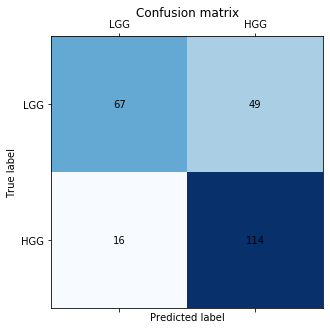

In [93]:
plots.plot_model_performance(y_test, pred_test)

Model performance:
              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80       116
         1.0       0.78      0.94      0.85       130

    accuracy                           0.83       246
   macro avg       0.85      0.82      0.82       246
weighted avg       0.84      0.83      0.83       246



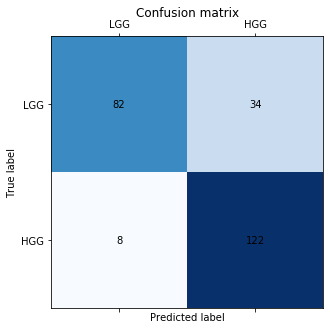

In [94]:
plots.plot_model_performance(y_test, new_pred)

We can see that our adjusted prediciton boosted performance. Accuracy is higher about 10%, but also other metrics show improvement. Number of corrected  samples are visible in confusion matrices.

This visualization shows that our metrics can give as some helpful information about confidence of prediciton. 

### Use cases

Lest show some predicted samples and confidence of prediction. In the picture is shown described visualization for each prediction, but in this case visualization is enriched witch graph of confidence, which show if of method agree with prediction or othervise.

In [103]:
generator = test_generator.get_image_seg_generator(batch_size)

Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


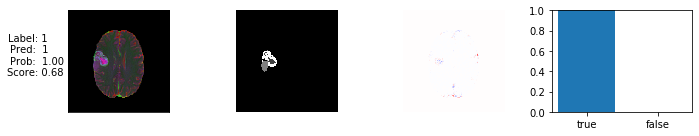

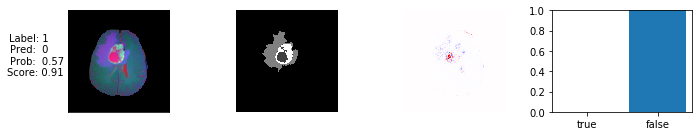

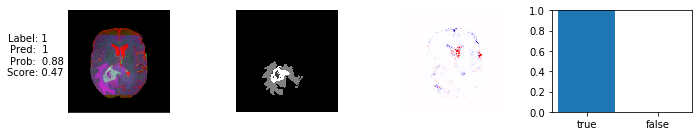

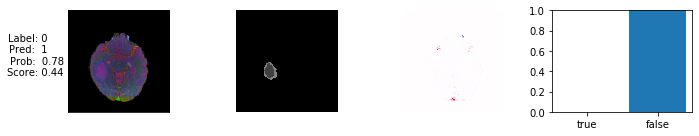

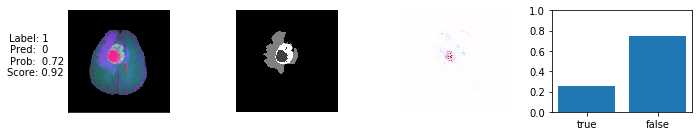

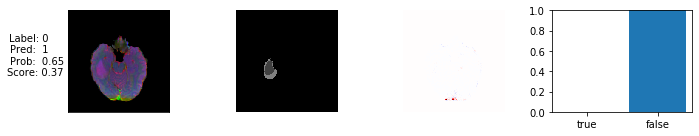

In [111]:
(x, y),(x_seg, y_seg) = next(generator)
evaluation.visualize_prediction_confidence(model, analyzer, neigh, x, x_seg, y)